In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
!pip install pytorch-gradcam
from copy import deepcopy
from IPython.display import Audio
from module import models_lib
from module import config_lib, utils_lib

In [4]:

class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = "/kaggle/input/bc25-models-fold0-mel-0411"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            self.model_path =  "../models/mel_cleaned0413/"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 64
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        


        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            
    
            
cfg = CFG(mode="inference", kaggle_notebook=False, debug=False)




In [5]:

utils_lib.set_seed(cfg.seed)

In [6]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [7]:
train_label.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [8]:
taxonomy.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [9]:

models = models_lib.load_models(cfg, 206)
model = models[0]

Found a total of 5 model files.
Loading model: ../models/mel_cleaned0413/model_fold0.pth


/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:215: UserWarning: 
NVIDIA H100 PCIe with CUDA capability sm_90 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_60 sm_70 sm_75 compute_70 compute_75.
If you want to use the NVIDIA H100 PCIe GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


Loading model: ../models/mel_cleaned0413/model_fold1.pth
Loading model: ../models/mel_cleaned0413/model_fold2.pth
Loading model: ../models/mel_cleaned0413/model_fold3.pth
Loading model: ../models/mel_cleaned0413/model_fold4.pth


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from gradcam import GradCAM
from gradcam.utils import visualize_cam
from torchvision import transforms

# === 1. Melスペクトログラム画像をTensorに変換 ===
def prepare_input_from_melspec(mel_numpy):
    mel_norm = (mel_numpy - mel_numpy.min()) / (mel_numpy.max() - mel_numpy.min() + 1e-6)
    mel_tensor = torch.tensor(mel_norm).unsqueeze(0).unsqueeze(0).float()  # shape: (1, 1, H, W)
    return mel_tensor

# === Conv2dモジュール（オブジェクト）を返すバージョン ===
def get_last_conv_layer(model):
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("Conv2d 層が見つかりません")



def show_gradcam(model, mel_numpy, target_class, title="Grad-CAM"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    input_tensor = prepare_input_from_melspec(mel_numpy).to(device)

    target_layer = get_last_conv_layer(model)

    cam = GradCAM(model, target_layer)
    mask, _ = cam(input_tensor, target_class)

    # 可視化
    heatmap, result = visualize_cam(mask, input_tensor[0])
    heatmap = np.transpose(heatmap, (1, 2, 0))  # (H, W, C)
    result = np.transpose(result, (1, 2, 0))

    # === 上下を正しく表示するために上下反転 ===
    heatmap = np.flipud(heatmap)
    result = np.flipud(result)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [12]:
spec = np.load("../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
working_df = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

In [13]:
df = working_df[(working_df["rating"] == 5.0) & (working_df["duration_sec"] < 10)]
df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
231,22976,[''],['advertisement call'],22976/XC893972.ogg,XC,5.0,https://xeno-canto.org/893972,20.4215,-88.4714,Leptodactylus fragilis,...,22976-XC893972,Amphibia,center,7.488000,0,7.488000,0,False,22976-XC893972,2
297,41663,[''],['call'],41663/XC697007.ogg,XC,5.0,https://xeno-canto.org/697007,49.1523,2.3752,Procyon lotor,...,41663-XC697007,Mammalia,center,7.105000,0,7.105000,0,False,41663-XC697007,4
508,517119,[''],['advertisement call'],517119/XC893992.ogg,XC,5.0,https://xeno-canto.org/893992,10.9747,-84.7441,Rhinella horribilis,...,517119-XC893992,Amphibia,center,6.164906,0,6.164906,0,False,517119-XC893992,4
709,65373,[''],['advertisement call'],65373/XC941284.ogg,XC,5.0,https://xeno-canto.org/941284,9.0443,-79.3026,Dendropsophus microcephalus,...,65373-XC941284,Amphibia,center,7.720313,0,7.720313,0,False,65373-XC941284,4
921,amakin1,[''],['song'],amakin1/XC128804.ogg,XC,5.0,https://xeno-canto.org/128804,-16.7581,-56.8764,Chloroceryle amazona,...,amakin1-XC128804,Aves,center,9.816000,0,9.816000,0,False,amakin1-XC128804,1


In [16]:
working_df

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,1139490-CSA36385,Insecta,center,98.853375,0,7.000000,0,False,1139490-CSA36385,1
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,...,1139490-CSA36389,Insecta,center,96.537719,0,7.000000,0,False,1139490-CSA36389,3
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,1192948-CSA36358,Insecta,center,116.599812,0,7.000000,0,False,1192948-CSA36358,0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,...,1192948-CSA36366,Insecta,center,105.446313,0,7.000000,0,False,1192948-CSA36366,1
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,...,1192948-CSA36373,Insecta,center,103.631469,0,7.000000,0,False,1192948-CSA36373,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,...,ywcpar-iNat77392,Aves,center,3.392000,0,3.392000,0,False,ywcpar-iNat77392,3
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,...,ywcpar-iNat78624,Aves,center,7.659688,0,7.659688,0,False,ywcpar-iNat78624,4
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,...,ywcpar-iNat789234,Aves,center,7.666656,0,7.666656,0,False,ywcpar-iNat789234,3
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,...,ywcpar-iNat819873,Aves,center,27.036750,0,27.036750,0,False,ywcpar-iNat819873,1


In [14]:
i = 15
filename=df["filename"].iloc[i]
utils_lib.play_audio(filename, cfg.train_datadir)

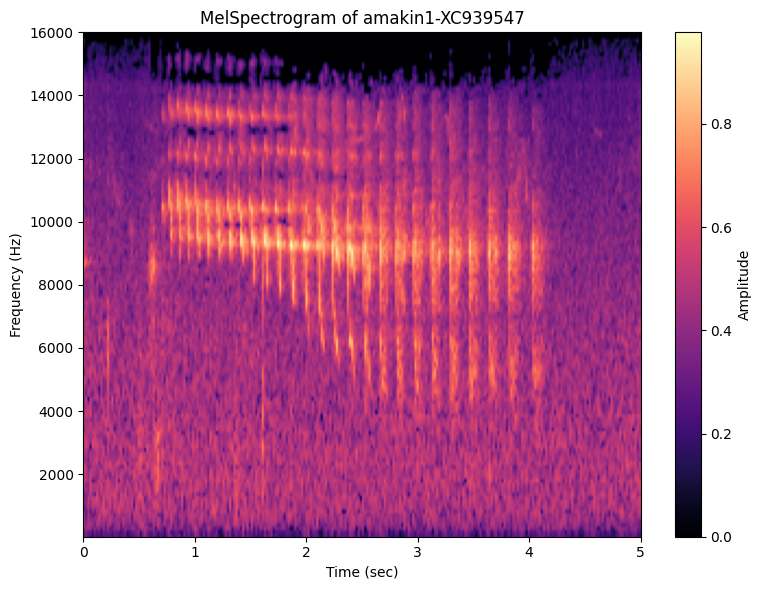

In [15]:
# 表示したい species_id を指定（例: 'pitangsp'）
samplename= df["samplename"].iloc[i] 
species_id = samplename # 実際のIDに置き換えてください

# Melスペクトログラムを取得
mel = spec[species_id]  # shape: (256, 256)

n_mels = 148  # 例: 256
fmin = 20           # 実際に使用したfmin
fmax = 16000           # 実際に使用したfmax
duration = 5.0         # メルスペクトログラムの時間（秒）

# X軸（時間）と Y軸（周波数）の範囲指定
extent = [0, duration, fmin, fmax]  # [x_min, x_max, y_min, y_max]

# 表示
plt.figure(figsize=(8, 6))
plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
plt.title(f"MelSpectrogram of {species_id}")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

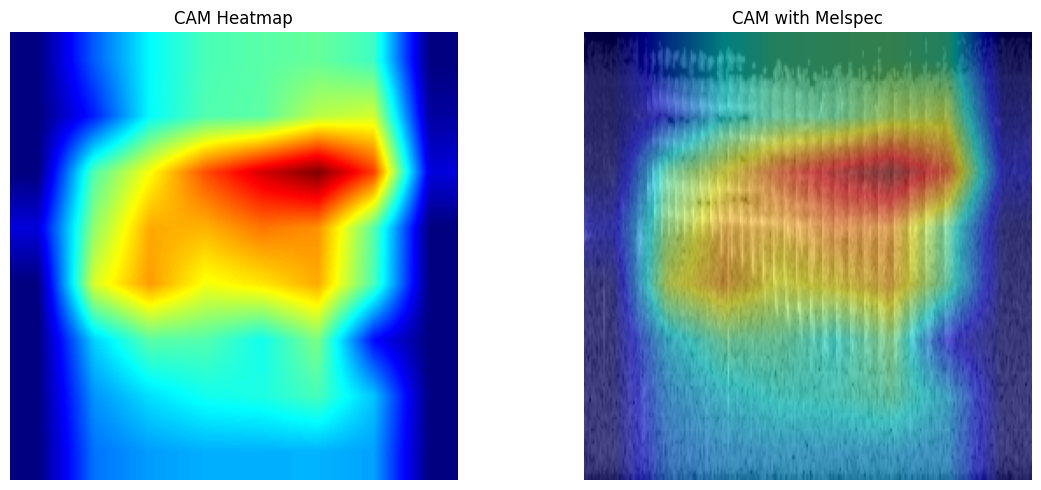

target_class: 60
samplename: amakin1-XC939547


In [ ]:
mel = spec[samplename]  # Melスペクトログラム（NumPy形式）
model = models[0]  # あなたのモデル
target_class = df["target"].iloc[i]  # 例：注目するspeciesのclass index

show_gradcam(model, mel, target_class, title="CAM with Melspec")
print("target_class:", target_class)
print("samplename:", samplename)

In [23]:
import matplotlib.pyplot as plt
import librosa.display

# ---- パラメータ（MelSpec生成と一致させてください） ----
fmin = 100
fmax = 16000
sr = 32000
hop_length = 16  # Mel生成に使った値
duration_sec = 5  # MelSpec 1枚あたりの長さ（秒）
n_mels = 148      # 実際のMelSpecの縦サイズ

# ---- Amphibiaクラスだけ抽出 ----
amphibia_df = working_df[working_df["class"] == "Amphibia"]

# ---- 各ラベルごとに rating の高い代表を1件抽出 ----
top_samples = (
    amphibia_df.sort_values("rating", ascending=False)
    .groupby("primary_label")
    .first()
    .reset_index()  # ← これで primary_label が列に戻る
)


In [32]:


def show_mel_and_play(samplename, working_df, spec, cfg):
    # --- メタ情報取得 ---
    row = working_df[working_df["samplename"] == samplename].iloc[0]
    mel = spec[samplename]
    filename = row["filename"]
    scientific_name = row.get("scientific_name", samplename)

    # --- Mel表示設定 ---
    fmin = cfg.FMIN
    fmax = cfg.FMAX
    duration = cfg.TARGET_DURATION
    extent = [0, duration, fmin, fmax]

    # --- 描画 + 音声再生 ---
    plt.figure(figsize=(8, 4))
    plt.imshow(mel, aspect='auto', origin='lower', cmap='magma', extent=extent)
    plt.title(f"{scientific_name} ({samplename})")
    plt.xlabel("Time (sec)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Normalized Amplitude")
    plt.tight_layout()
    plt.show()
    
    print(f"filename: {filename}")

    # --- 音声再生 ---
    print("🔊 再生中...")
    display(utils_lib.play_audio(filename, cfg.train_datadir))


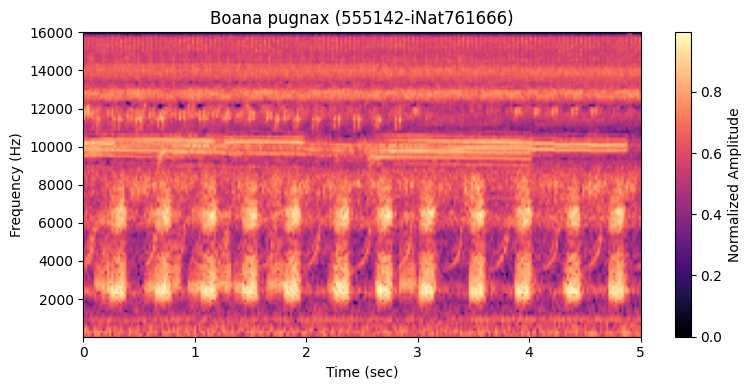

filename: 555142/iNat761666.ogg
🔊 再生中...


In [68]:
i = 16
samplename=top_samples["samplename"][i]
show_mel_and_play(samplename, working_df, spec, cfg)

In [ ]:
# Amphibia 音源とmelチェック 
# 126247/XC941297.ogg 1k以上
# 134933/XC941298.ogg 高周波？　melで確認できない
# 135045/iNat1207347.ogg 8k以上
# 21038/iNat65519.ogg 6K以上  
# 21116/iNat65520.ogg ギー低周波　確認不可
# 21211/XC934741.ogg 高い．6K以上
# 22333/XC890507.ogg　高い 5K以上
# 22973/XC892927.ogg 高い 3K以上
# 22976/XC893971.ogg 高い 3k以上
# 24272/XC893991.ogg 低い 1.5K以上
# 24292/CSA34651.ogg 低い 2K以上
# 24322/XC915926.ogg　低い 1.5k以上
# 476537/CSA35461.ogg 高い　フーンみたいな声 9k以上
# 476538/XC926710.ogg 低い？　ゲコッ？ 1k以上
# 517119/XC893994.ogg 低い　ゲココ 1k以上
# 555086/XC892928.ogg 高い 1k以上
# 555142/iNat761666.ogg 低い 1k以上



In [65]:
working_df[working_df["primary_label"] == "476538"]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,...,samplename,class,crop_strategy,duration_sec,valid_start_sec,valid_end_sec,n_augment,multi_crop,group_id,fold
453,476538,['65448'],['advertisement call'],476538/XC926710.ogg,XC,4.5,https://xeno-canto.org/926710,9.0709,-79.2983,Elachistocleis panamensis,...,476538-XC926710,Amphibia,center,38.962344,0,38.962344,0,False,476538-XC926710,4
454,476538,[''],[''],476538/iNat1109247.ogg,iNat,0.0,https://static.inaturalist.org/sounds/1109247.wav,9.0709,-79.2983,Elachistocleis panamensis,...,476538-iNat1109247,Amphibia,center,38.962344,0,38.962344,0,False,476538-iNat1109247,0
455,476538,[''],[''],476538/iNat955995.ogg,iNat,0.0,https://static.inaturalist.org/sounds/955995.m4a,9.1208,-79.7041,Elachistocleis panamensis,...,476538-iNat955995,Amphibia,center,27.817531,0,27.817531,0,False,476538-iNat955995,0
456,476538,[''],[''],476538/iNat955998.ogg,iNat,0.0,https://static.inaturalist.org/sounds/955998.wav,9.1208,-79.7041,Elachistocleis panamensis,...,476538-iNat955998,Amphibia,center,19.992375,0,19.992375,0,False,476538-iNat955998,2
457,476538,[''],[''],476538/iNat955999.ogg,iNat,0.0,https://static.inaturalist.org/sounds/955999.wav,9.1208,-79.7041,Elachistocleis panamensis,...,476538-iNat955999,Amphibia,center,19.992375,0,19.992375,0,False,476538-iNat955999,1


In [60]:
top_samples.shape

(34, 25)